In this notebook, we do a sanity check of the GNN by generating easy, fake data and seeing how well the GNN learns. 

The fake data consists of 
- X2 (input) as normal, 
- X1 set to the value of X2 from the right closest node. 

Guess what we forgot in all our previous GCN test? Normalizing the adjacency matrix!! Why does this matter? I'm not sure yet of the mathematical implications! 

This seems like it could potentially be a major issue though, so let's redo all the code here but now add the preprocessing. 

### imports and setup

In [30]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [31]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDatasetWrapper
from plotters import plot_data
from tuning import make_train_GCN, plot_model_results

# from spektral.layers import GCNConv
# from spektral.transforms import LayerPreprocess
from spektral.utils import gcn_filter


In [33]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


## generate fake data

In [34]:
# first generate a Dataset object as normal so that we get the X1 data and have a convenient class object for holding things
# this may not be the most computationally efficient but it is convenient

# only uncomment each line if testing a non-default parameter
dataset = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=2_000,
    # transforms=None,
    transforms=[gcn_filter],
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=True,
    train_pct=
    1,  # no train/val split since we have so few data points and just want to ensure overfitting right now
    val_pct=0,
    test_pct=0,
    override=True)


done computing adj


In [35]:
dataset.train

lorenzDataset(n_graphs=2000)

In [36]:
dataset.train.a.todense()

matrix([[0.2, 0.2, 0.2, ..., 0. , 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0. , 0. , 0.2],
        [0.2, 0.2, 0.2, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0.2, 0.2, 0.2],
        [0.2, 0. , 0. , ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0. , ..., 0.2, 0.2, 0.2]])

In [37]:
dataset.buffer

lorenzDataset(n_graphs=100)

In [38]:
dataset.train

lorenzDataset(n_graphs=2000)

#### inspect data directly

In [39]:
dataset.buffer[0].x.flatten()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [40]:
dataset.buffer[0].y.flatten()

array([8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.00025011, 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 8.        , 8.        ,
       8.        ])

In [41]:
dataset.train[0].x.flatten()

array([-5.98500071e-01,  5.71229185e-02, -2.46832683e-01, -1.17663421e-01,
       -1.22312074e-01, -1.99922435e-01, -2.36465689e-01, -2.19236620e-01,
       -5.07344320e-01,  1.22268317e-01, -1.42369741e-01,  4.87719894e-01,
       -2.71941584e-01,  3.28530324e-05,  1.06667080e-01,  4.70253696e-01,
       -8.48744894e-01, -1.20729877e-01, -4.07813777e-01,  5.67882884e-01,
        5.47940270e-02,  4.90445135e-01,  7.14118677e-01, -2.16288540e-01,
        3.55399766e-02,  1.03311955e+00,  6.35760923e-02,  5.53524769e-03,
       -1.58068767e-01,  4.11570261e-01,  1.66965601e-01, -1.21909722e-01,
        8.14989852e-02, -1.01788170e-01,  2.67408814e-01,  1.60963209e-01])

In [42]:
dataset.train[1].x.flatten()

array([-0.50427848,  0.09165778, -0.27076661, -0.12074293, -0.13650017,
       -0.19801729, -0.19333907, -0.07231841, -0.53932719,  0.04161799,
        0.04740671,  0.42234787, -0.33195816, -0.26793083,  0.36586227,
        0.34668843, -0.79116765,  0.25980773, -0.20487176,  0.55957042,
       -0.04109169,  0.63831507,  0.63923599, -0.18590823, -0.25378529,
        1.03820164,  0.16663055,  0.04418336, -0.12364721,  0.47580954,
        0.07895667, -0.12105391,  0.11324171, -0.06614625,  0.32440429,
        0.09736667])

In [43]:
dataset.train[0].y.flatten()

array([  1.42795328,  -6.94434694,  -2.68492474,  -2.21881174,
        -0.76235718,  -1.58453345,   6.56540722,  -3.0709747 ,
        -7.89201501, -11.30572251,   0.39587265,   0.74841062,
        -7.22125485, -10.25998976,   0.20755034,   5.01608414,
        -8.69123399,  -6.41008286,  12.27441918,   4.90732838,
        -2.28286962,   5.90810174,  13.5497416 ,  -2.92313612,
         3.54461276,  12.5034548 ,   8.51098412,  -0.4469898 ,
         6.20162122,  11.2746325 ,  -2.90229209,  -3.3865137 ,
         0.65700206,   3.48193155,   6.36180742,   7.1602859 ])

In [44]:
dataset.train[0].y.shape

(36, 1)

In [45]:
dataset.train[1].y.flatten()

array([  0.55803039,  -6.89105591,  -2.35296448,  -2.27090004,
        -0.69499078,  -1.55127621,   6.62062751,  -3.3502737 ,
        -7.15522086, -11.35254978,  -0.46538502,   0.8140995 ,
        -7.14549982,  -9.99425524,  -0.94882787,   5.03708632,
        -8.8302228 ,  -6.85827319,  11.31405772,   5.43195077,
        -2.48822446,   5.72552176,  13.45100492,  -3.11277793,
         3.61464595,  12.84967398,   7.96821802,  -0.89427108,
         6.20124529,  11.07069172,  -3.83603137,  -2.916221  ,
         0.51227774,   3.583835  ,   6.60261322,   6.9341745 ])

#### replace all X2 data with shifted X1 data

the X1 (output) value of node n will be the X2 (input) value of node n+1

In [46]:
for sample in dataset.train:
    sample.y = np.concatenate([sample.x[1:], [sample.x[0]]])

for sample in dataset.buffer:
    sample.y = np.concatenate([sample.x[1:], [sample.x[0]]])

inspect data again

In [47]:
dataset.train[0].x.flatten()

array([-5.98500071e-01,  5.71229185e-02, -2.46832683e-01, -1.17663421e-01,
       -1.22312074e-01, -1.99922435e-01, -2.36465689e-01, -2.19236620e-01,
       -5.07344320e-01,  1.22268317e-01, -1.42369741e-01,  4.87719894e-01,
       -2.71941584e-01,  3.28530324e-05,  1.06667080e-01,  4.70253696e-01,
       -8.48744894e-01, -1.20729877e-01, -4.07813777e-01,  5.67882884e-01,
        5.47940270e-02,  4.90445135e-01,  7.14118677e-01, -2.16288540e-01,
        3.55399766e-02,  1.03311955e+00,  6.35760923e-02,  5.53524769e-03,
       -1.58068767e-01,  4.11570261e-01,  1.66965601e-01, -1.21909722e-01,
        8.14989852e-02, -1.01788170e-01,  2.67408814e-01,  1.60963209e-01])

In [48]:
dataset.train[0].y.flatten()

array([ 5.71229185e-02, -2.46832683e-01, -1.17663421e-01, -1.22312074e-01,
       -1.99922435e-01, -2.36465689e-01, -2.19236620e-01, -5.07344320e-01,
        1.22268317e-01, -1.42369741e-01,  4.87719894e-01, -2.71941584e-01,
        3.28530324e-05,  1.06667080e-01,  4.70253696e-01, -8.48744894e-01,
       -1.20729877e-01, -4.07813777e-01,  5.67882884e-01,  5.47940270e-02,
        4.90445135e-01,  7.14118677e-01, -2.16288540e-01,  3.55399766e-02,
        1.03311955e+00,  6.35760923e-02,  5.53524769e-03, -1.58068767e-01,
        4.11570261e-01,  1.66965601e-01, -1.21909722e-01,  8.14989852e-02,
       -1.01788170e-01,  2.67408814e-01,  1.60963209e-01, -5.98500071e-01])

#### normalize

In [49]:
dataset.normalize()

#### inspect data after normalization

In [50]:
dataset.buffer[0].x.flatten()

array([3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048])

In [51]:
dataset.buffer[0].y.flatten()

array([3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048, 3.48803048, 3.48803048, 3.48803048, 3.48803048,
       3.48803048])

In [52]:
dataset.train[0].x.flatten()

array([-2.60310163, -0.10483071, -1.26306258, -0.77085927, -0.78857309,
       -1.08430968, -1.22355884, -1.15790696, -2.25574993,  0.14340777,
       -0.86500343,  1.53597188, -1.3587408 , -0.32237411,  0.08395879,
        1.46941642, -3.55666698, -0.78254409, -1.87648583,  1.84143534,
       -0.11370502,  1.54635649,  2.39867119, -1.14667322, -0.18707316,
        3.6142335 , -0.0802407 , -0.30140707, -0.92482504,  1.24580144,
        0.3137281 , -0.78703992, -0.01194499, -0.71036615,  0.69646995,
        0.29085581])

In [53]:
dataset.train[1].x.flatten()

array([-2.24406745,  0.02676541, -1.35426352, -0.78259381, -0.84263725,
       -1.07705009, -1.05922357, -0.59807073, -2.37762161, -0.16391271,
       -0.14185461,  1.28686986, -1.58743574, -1.34345769,  1.07162977,
        0.99856731, -3.33726719,  0.66750579, -1.10316922,  1.80976047,
       -0.47908042,  2.10981929,  2.11332846, -1.03090814, -1.28955572,
        3.63359895,  0.31245138, -0.15413728, -0.79366067,  1.49058711,
       -0.02163254, -0.78377883,  0.10901162, -0.57455155,  0.91365293,
        0.0485193 ])

In [54]:
dataset.train[0].y.flatten()

array([-0.10483071, -1.26306258, -0.77085927, -0.78857309, -1.08430968,
       -1.22355884, -1.15790696, -2.25574993,  0.14340777, -0.86500343,
        1.53597188, -1.3587408 , -0.32237411,  0.08395879,  1.46941642,
       -3.55666698, -0.78254409, -1.87648583,  1.84143534, -0.11370502,
        1.54635649,  2.39867119, -1.14667322, -0.18707316,  3.6142335 ,
       -0.0802407 , -0.30140707, -0.92482504,  1.24580144,  0.3137281 ,
       -0.78703992, -0.01194499, -0.71036615,  0.69646995,  0.29085581,
       -2.60310163])

In [55]:
dataset.train[1].y.flatten()

array([ 0.02676541, -1.35426352, -0.78259381, -0.84263725, -1.07705009,
       -1.05922357, -0.59807073, -2.37762161, -0.16391271, -0.14185461,
        1.28686986, -1.58743574, -1.34345769,  1.07162977,  0.99856731,
       -3.33726719,  0.66750579, -1.10316922,  1.80976047, -0.47908042,
        2.10981929,  2.11332846, -1.03090814, -1.28955572,  3.63359895,
        0.31245138, -0.15413728, -0.79366067,  1.49058711, -0.02163254,
       -0.78377883,  0.10901162, -0.57455155,  0.91365293,  0.0485193 ,
       -2.24406745])

#### plot data

plotting train
no val data to plot
no training data to plot
editing legend


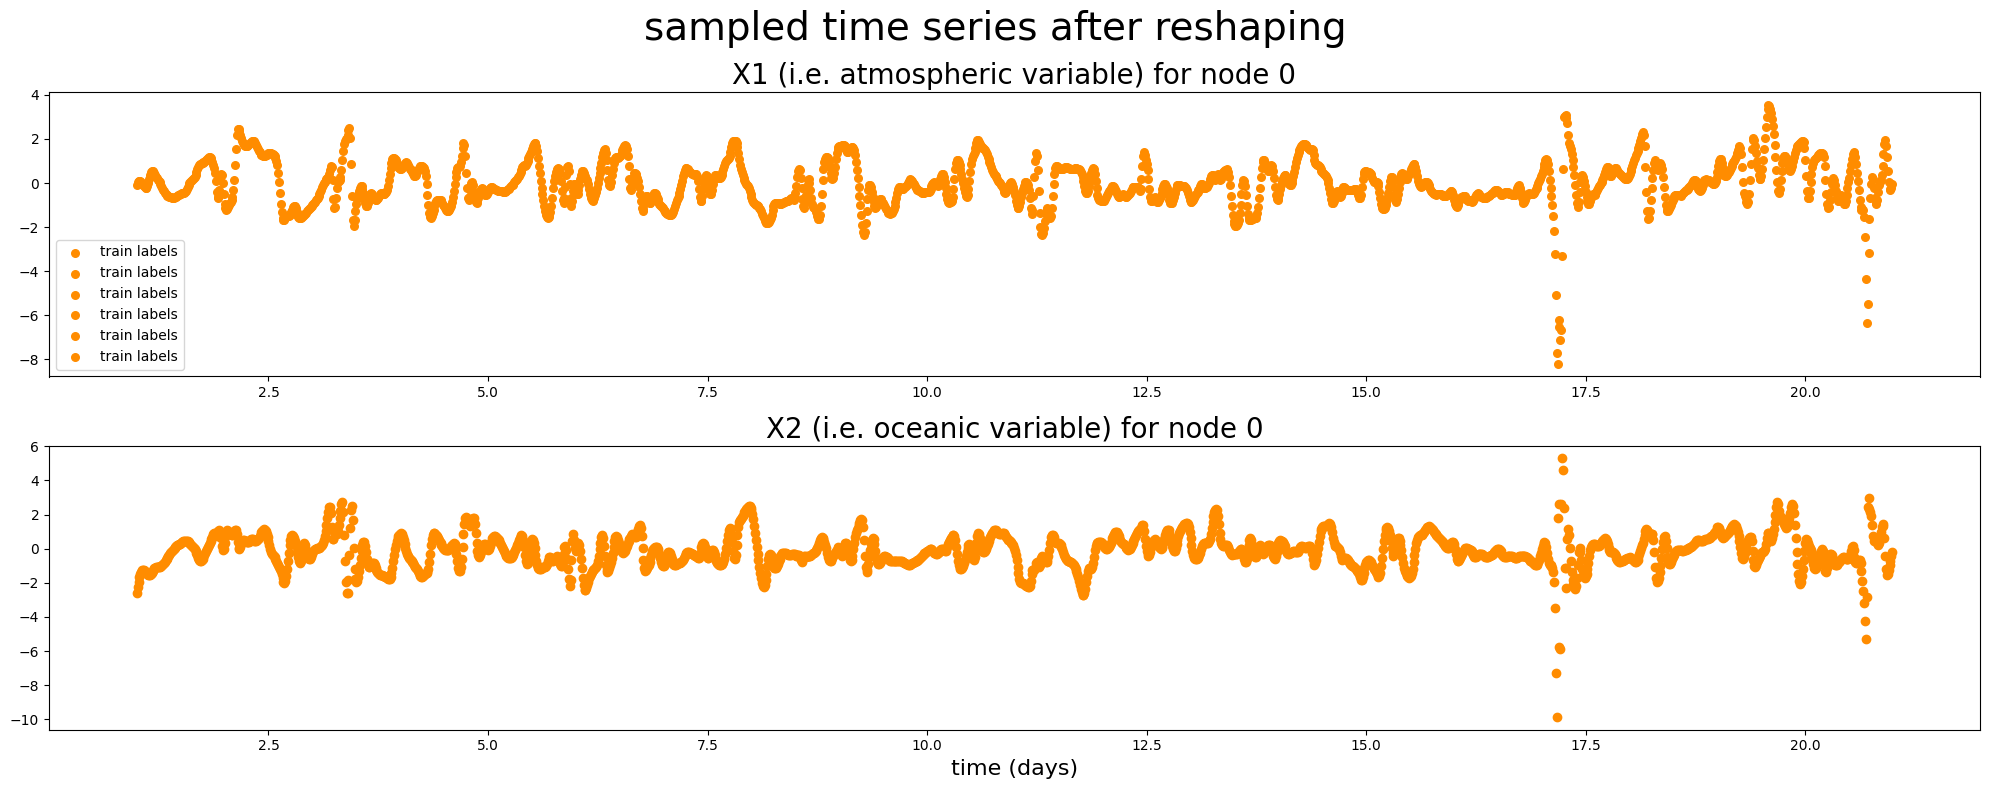

In [56]:
fig, (ax0, ax1) = plot_data(dataset.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


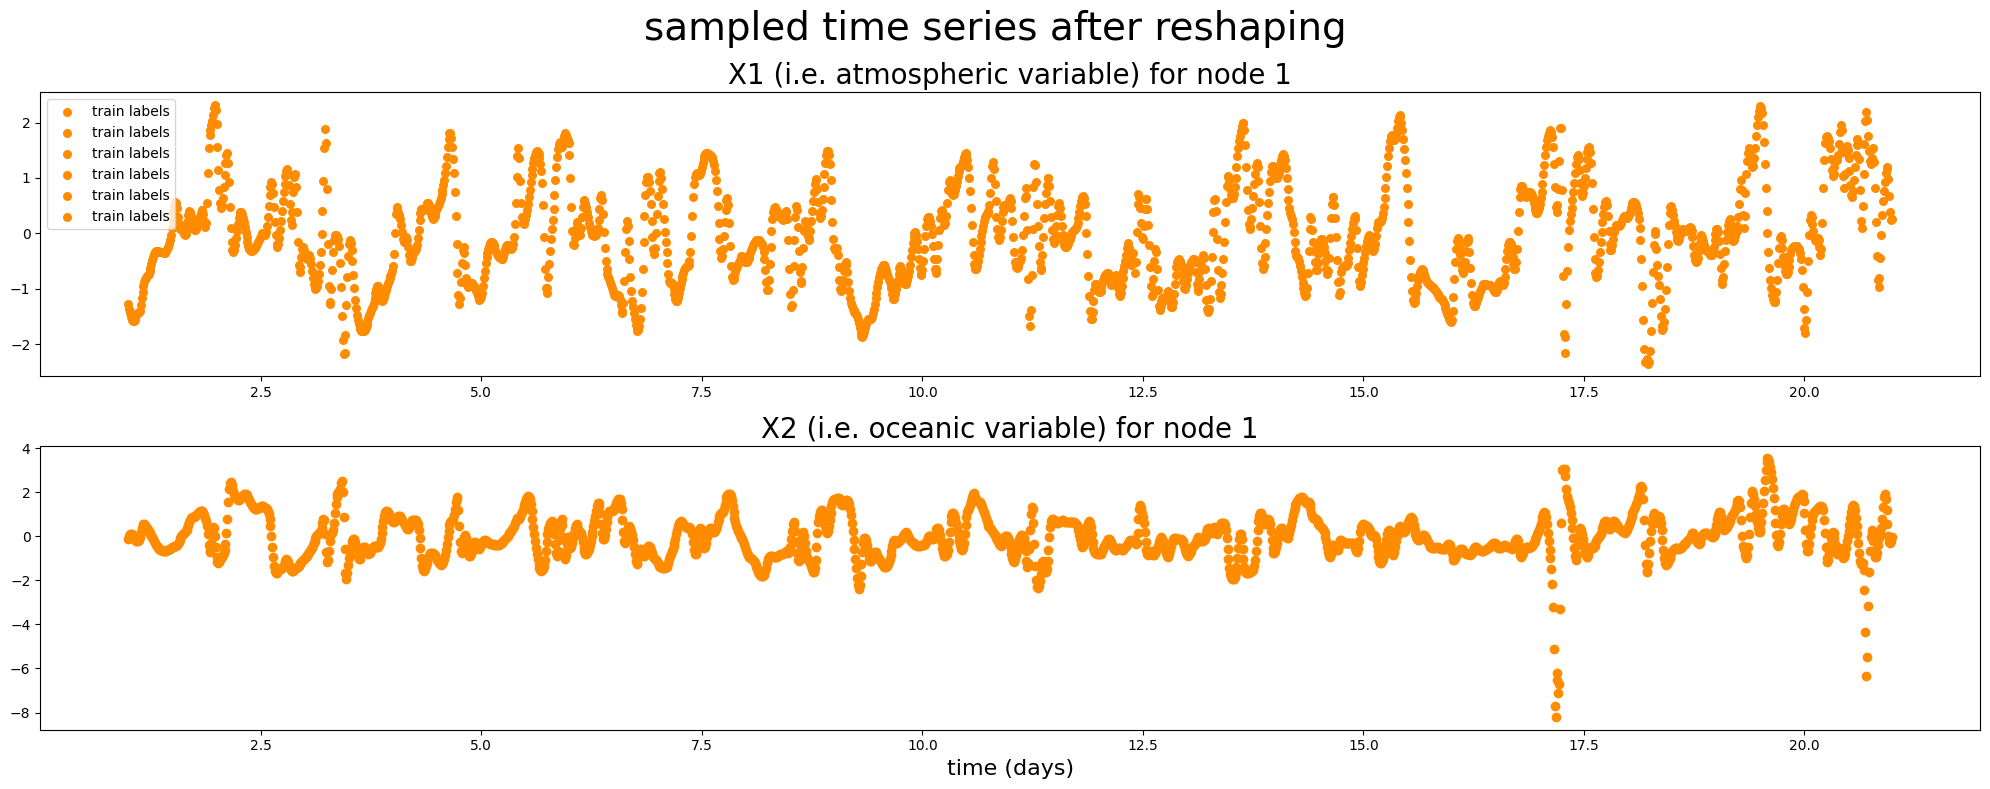

In [57]:
fig, (ax0, ax1) = plot_data(dataset.train, node=1, alpha=1)

plt.tight_layout()
plt.show()

In [58]:
# fig, (ax0, ax1) = plot_data(dataset.train, node=2, alpha=1)

# plt.tight_layout()
# plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


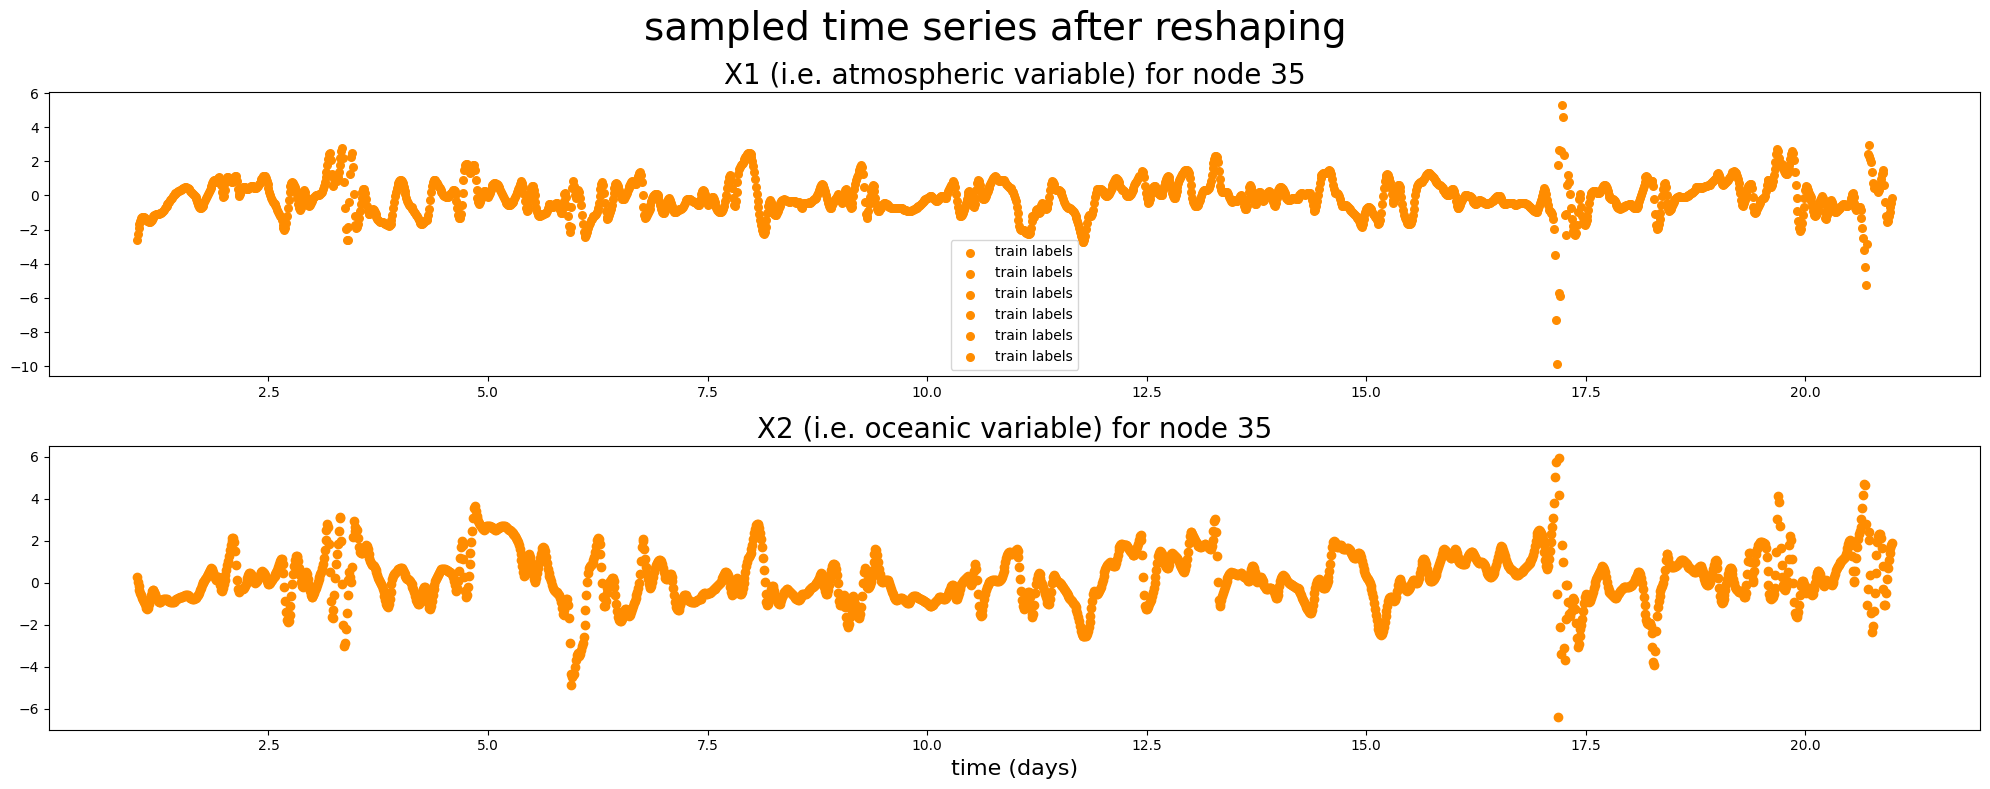

In [59]:
fig, (ax0, ax1) = plot_data(dataset.train, node=35, alpha=1)

plt.tight_layout()
plt.show()

In [60]:
# # plot all the X2 data against the X1 data
# # warning, takes a long time for even medium-sized datasets
# colors = plt.cm.tab10(np.linspace(0, 1, dataset.train.n_nodes))
# ax = plt.subplot(1, 1, 1)

# for n in range(dataset.train.n_nodes):
#     for g in dataset.train:
#         ax.scatter(g.x[n], g.y[n], color=colors[n], label='node {}'.format(n))

# ax.set_xlabel('X2')
# ax.set_ylabel('X1')
# ax.set_title('plot of X1 against X2 data for all nodes')
# ax.legend()

## train a 2-layer GCN

#### 36 channels

In [61]:
GCN_2000_36, history_2000_36, fname_2000_36 = make_train_GCN(dataset.train,
                                           val=None,
                                           channels=36,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=500,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0,
                                           tensorboard=True)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn-20230329-164617/assets


INFO:tensorflow:Assets written to: saved_models/gcn-20230329-164617/assets


In [62]:
GCN_2000_36.summary()

Model: "gcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0         
                                                                 
 gcn_conv (GCNConv)          multiple                  36        
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_1 (GCNConv)        multiple                  36        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 0s 4ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>,
 <Figure size 2500x18000 with 108 Axes>,
 None)

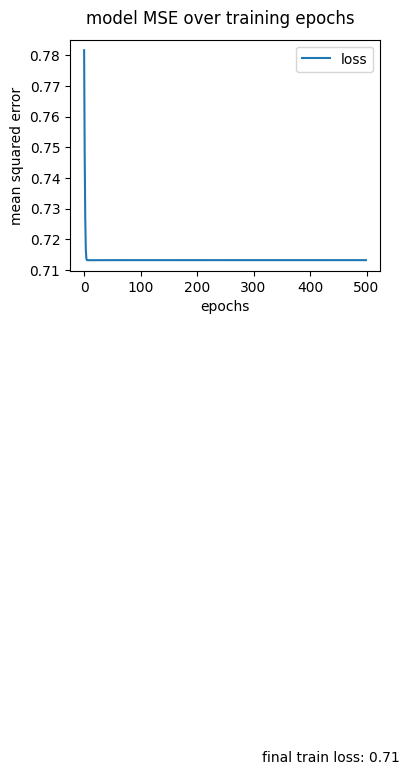

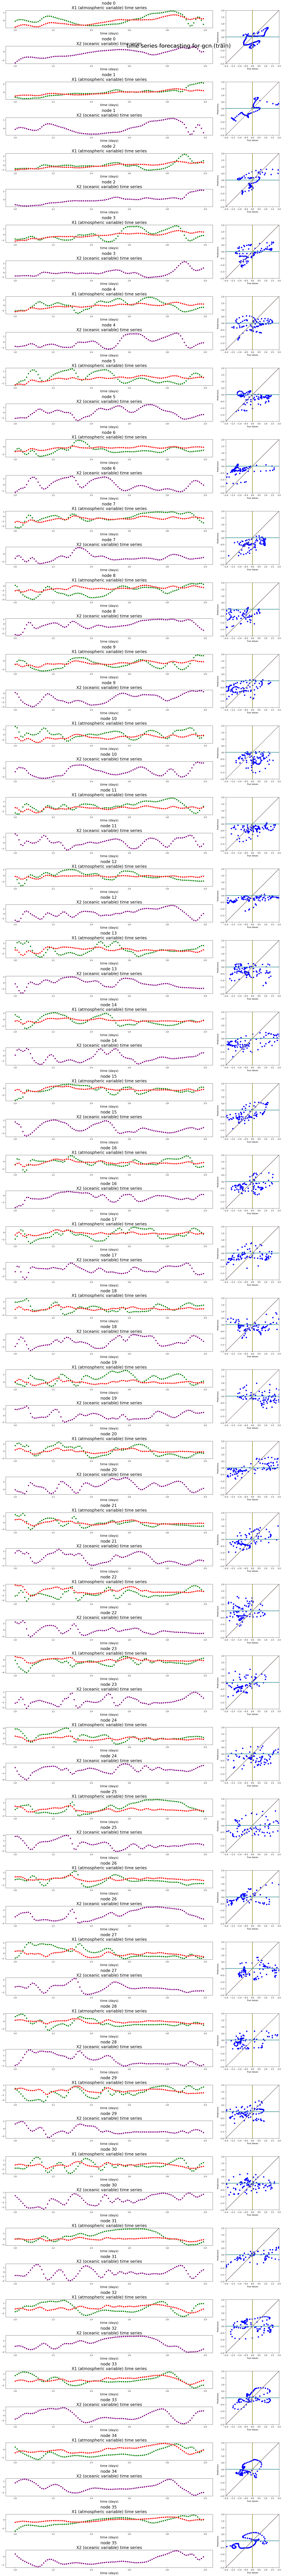

In [63]:
plot_model_results(dataset.train[:100],
                   None,
                   GCN_2000_36, history_2000_36, fname_2000_36,
                   nodes=range(36))


It's nice that the MSE is below 1. nevertheless, I was expecting the results to be way better since we gave it such an easy problem. what gives? 

I think we should investigate the actual model architecture next. 

Real quick, let's do some other small tests:

#### use fewer channels

In [64]:
GCN_2000_4, history_2000_4, fname_2000_4 = make_train_GCN(dataset.train,
                                           val=None,
                                           channels=4,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=100,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_1-20230329-165157/assets


INFO:tensorflow:Assets written to: saved_models/gcn_1-20230329-165157/assets


In [65]:
GCN_2000_4.summary()

Model: "gcn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_2 (GCNConv)        multiple                  4         
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_3 (GCNConv)        multiple                  4         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 0s 4ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x2500 with 15 Axes>, None)

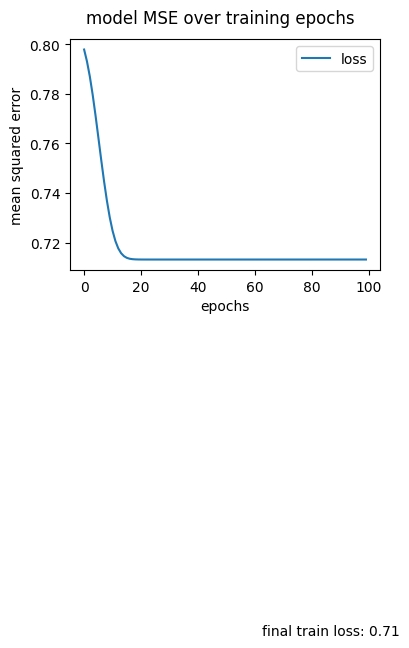

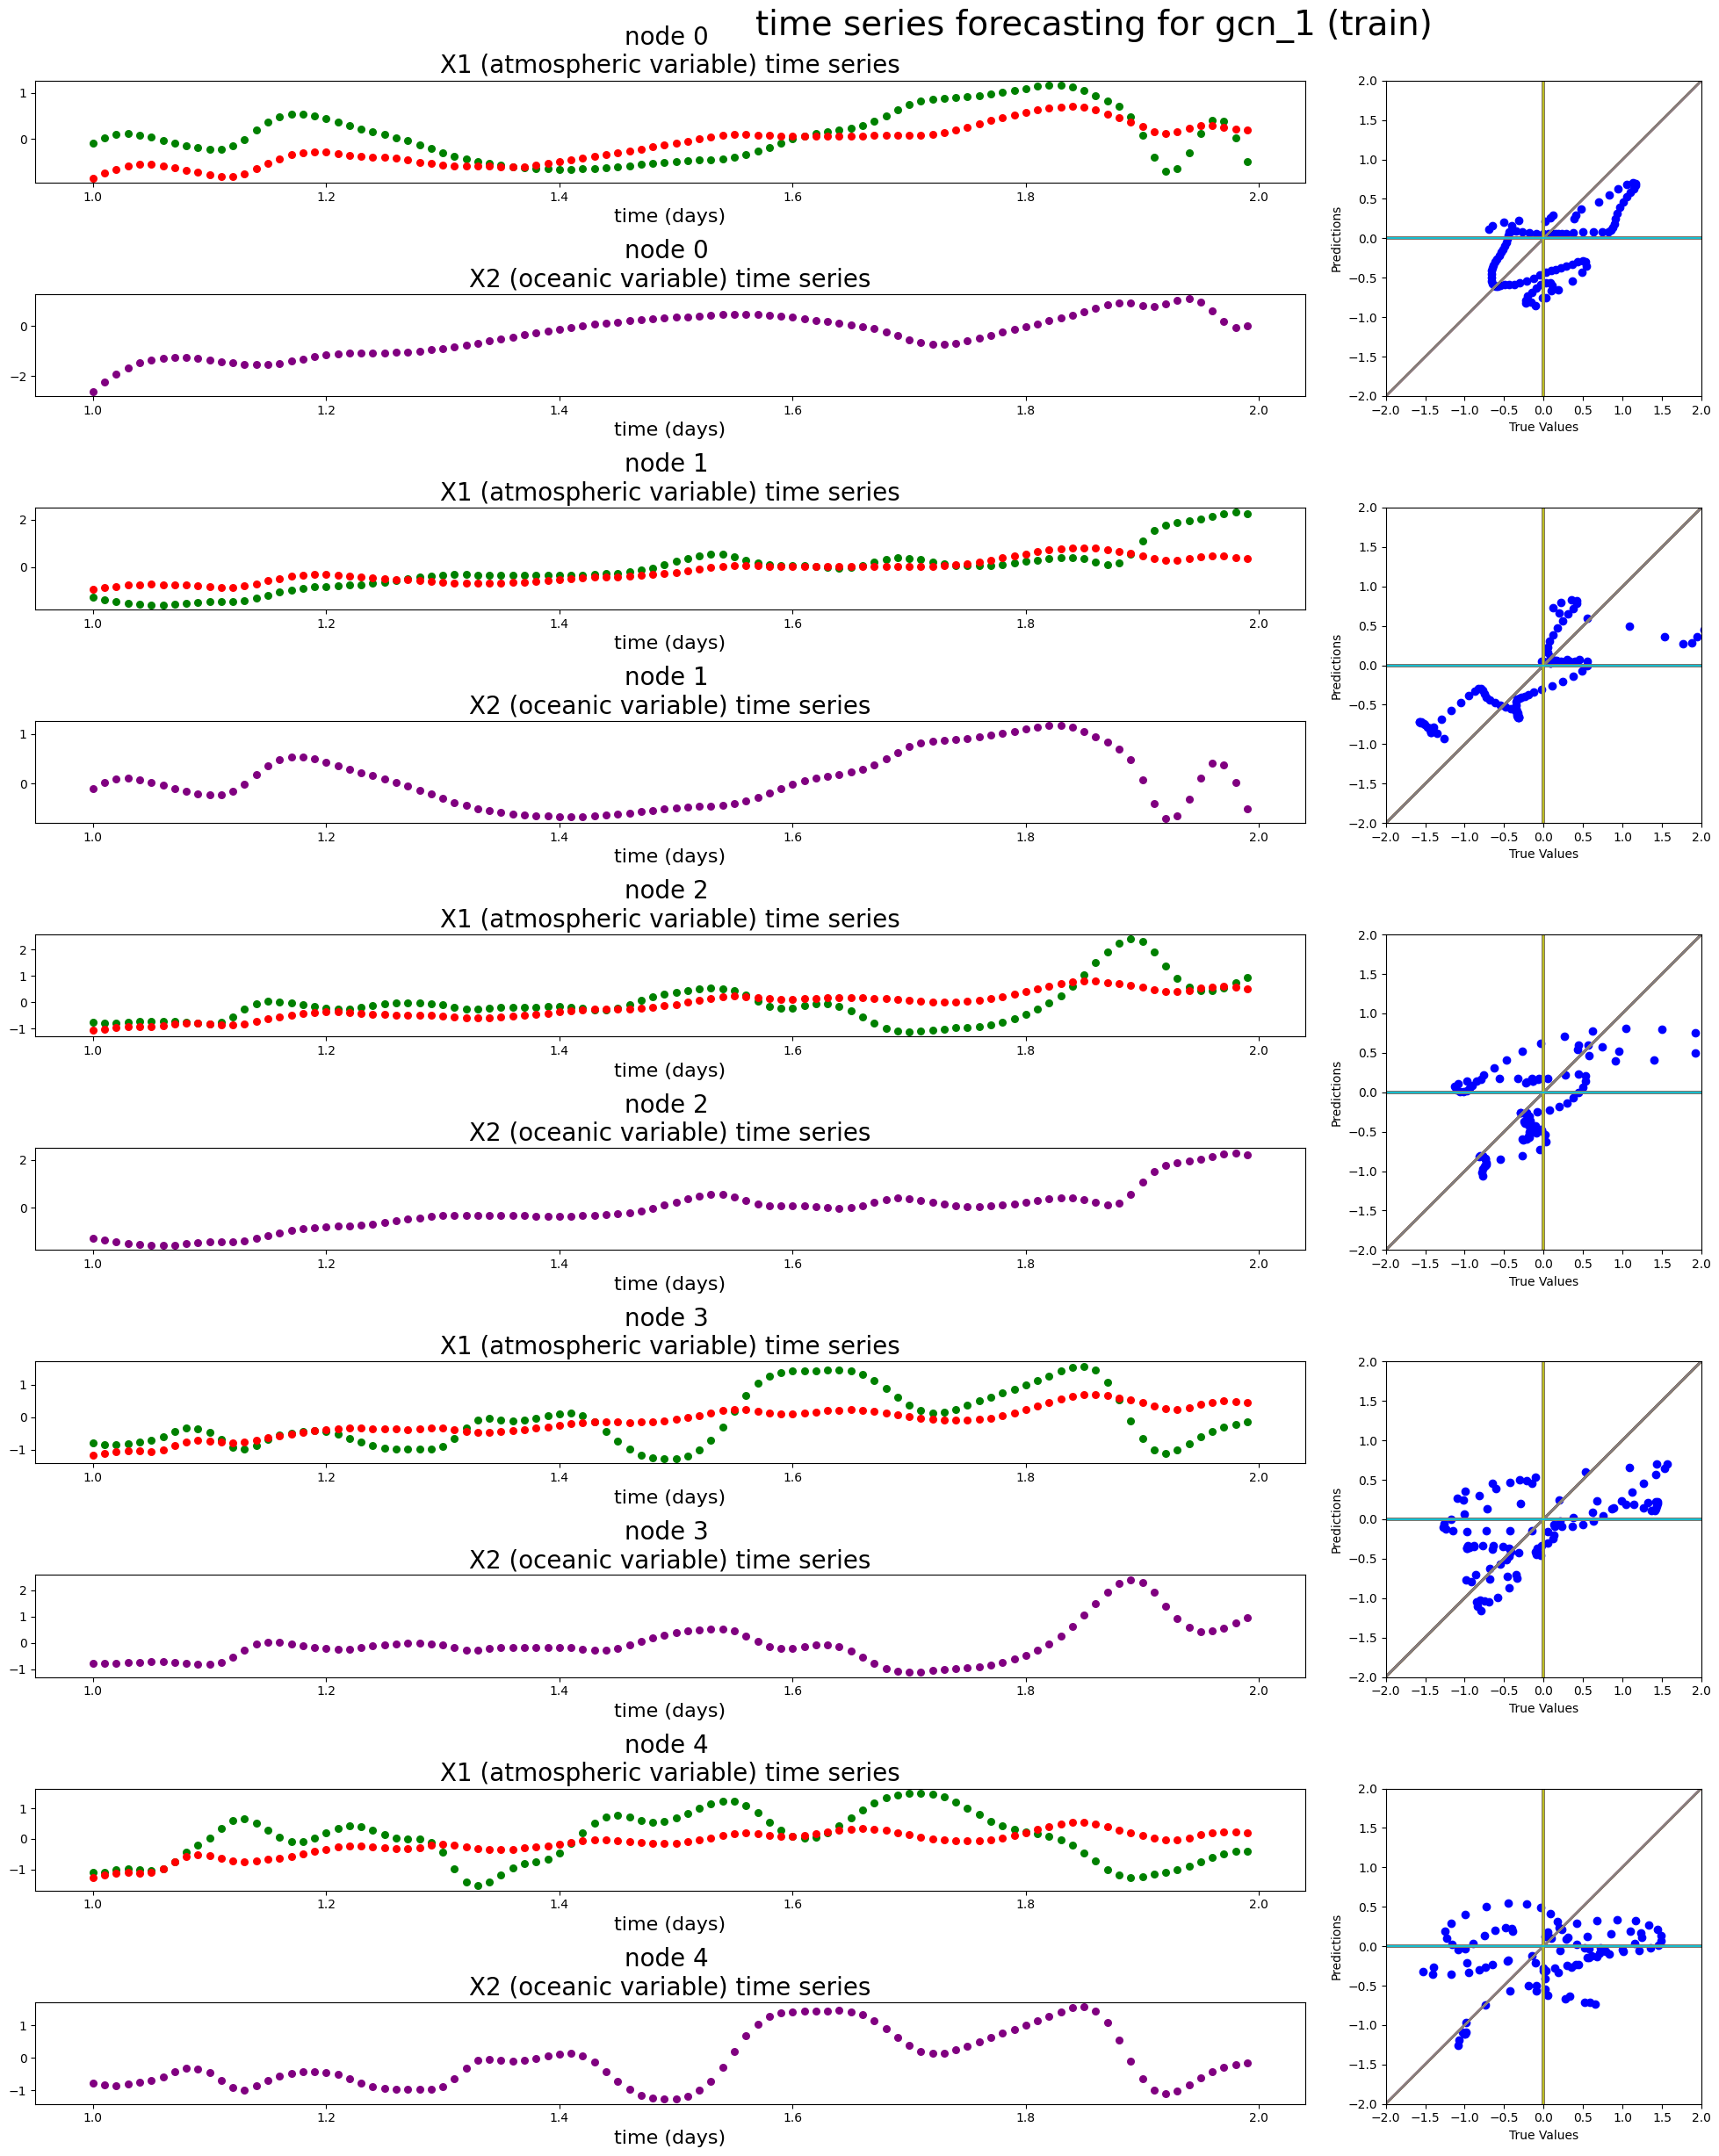

In [66]:
plot_model_results(dataset.train[:100],
                   None,
                   GCN_2000_4, history_2000_4, fname_2000_4,
                   nodes=range(5))


also tested 1, 2, and 3 channels, which were marginally worse (~0.78-0.81 MSE). looks like 4 channels is the best performance we can get for some reason. 

theoretically, though, we should only need 1 channel (since our only data manipulation is a spatial shift)

#### use more channels

In [67]:
GCN_2000_64, history_2000_64, fname_2000_64 = make_train_GCN(dataset.train,
                                           val=None,
                                           channels=64,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=100,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_2-20230329-165246/assets


INFO:tensorflow:Assets written to: saved_models/gcn_2-20230329-165246/assets


In [68]:
GCN_2000_64.summary()

Model: "gcn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_4 (GCNConv)        multiple                  64        
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 gcn_conv_5 (GCNConv)        multiple                  64        
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


4/4 [==============================] - 0s 4ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x2500 with 15 Axes>, None)

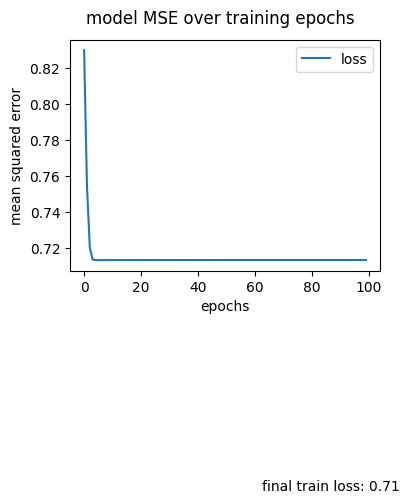

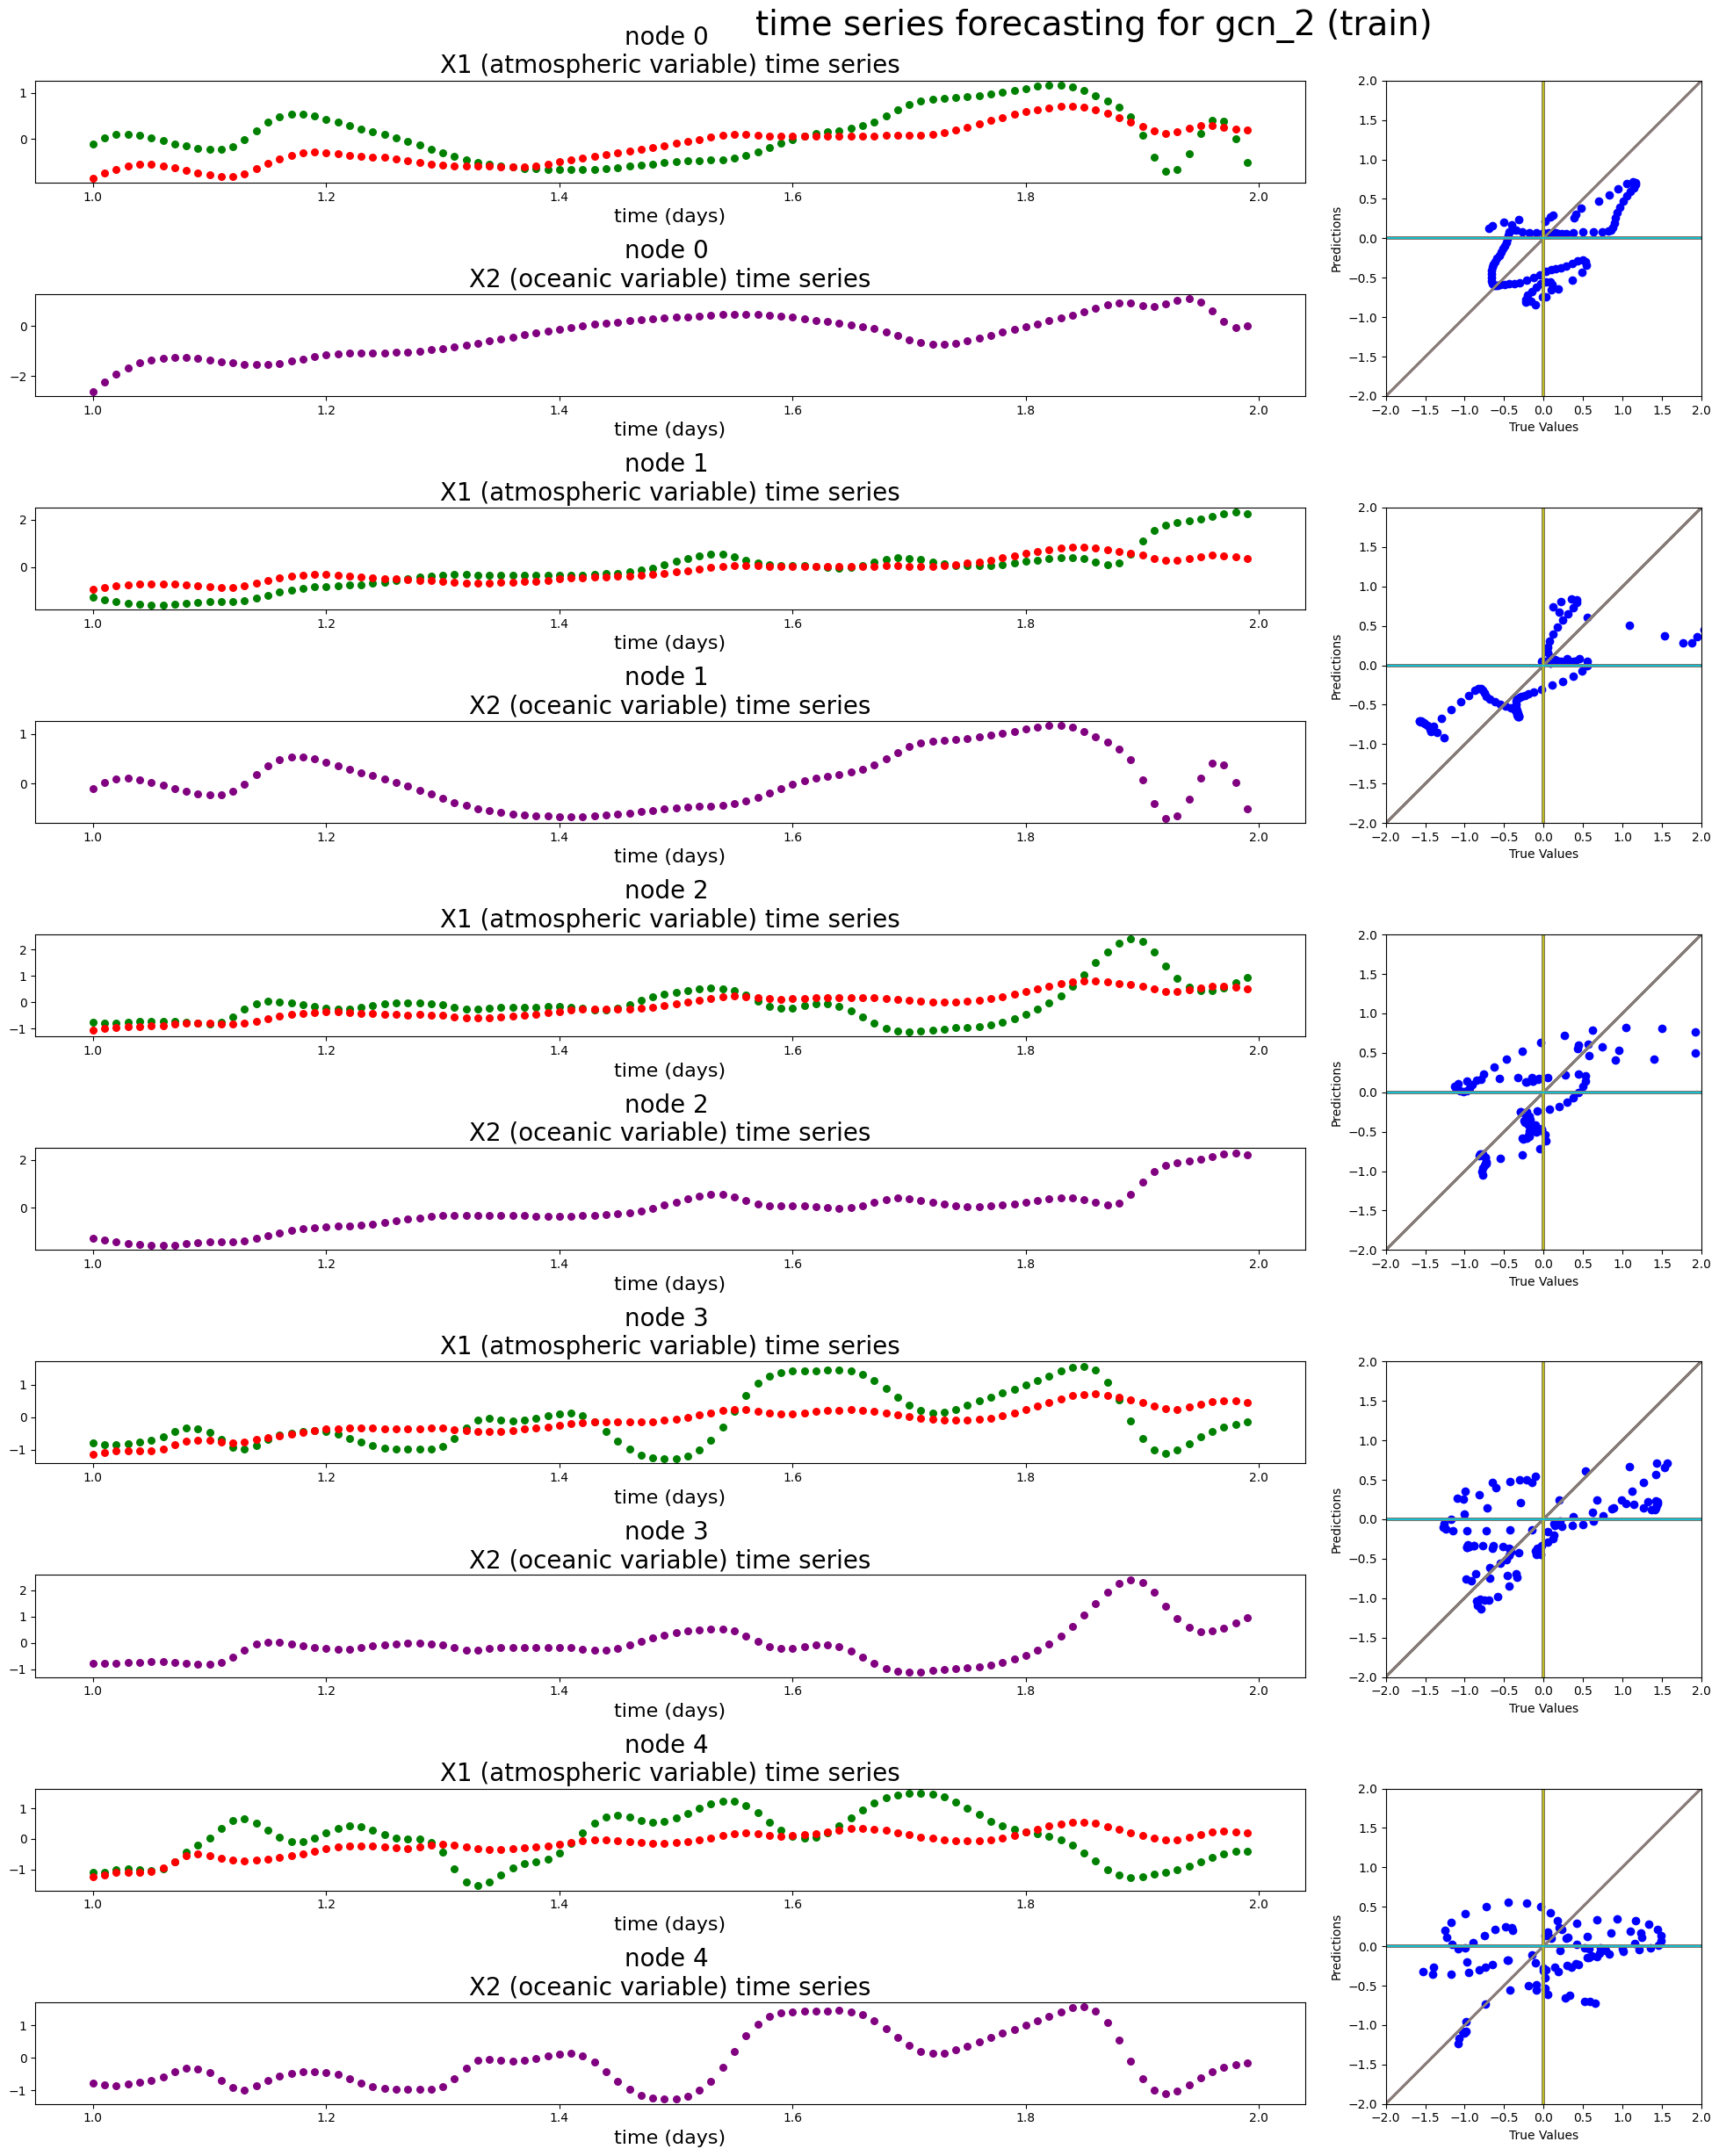

In [69]:
plot_model_results(dataset.train[:100],
                   None,
                   GCN_2000_64, history_2000_64, fname_2000_64,
                   nodes=range(5))


why is MSE all plateauing around 0.7? the actual predictions all look pretty similar regardless of number of channels used. 